In [2]:
import pandas_datareader as pdr

In [3]:
key=''

In [4]:
df = pdr.get_data_tiingo('GOOG', api_key=key)

In [5]:
df.to_csv('goog.csv')

In [6]:
import pandas as pd

In [7]:
df=pd.read_csv('goog.csv')

In [8]:
df.tail()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1252,GOOG,2021-12-13 00:00:00+00:00,2934.09,2971.2500,2927.20,2968.88,1205196,2934.09,2971.2500,2927.20,2968.88,1205196,0.0,1.0
1253,GOOG,2021-12-14 00:00:00+00:00,2899.41,2908.8400,2844.85,2895.40,1238940,2899.41,2908.8400,2844.85,2895.40,1238940,0.0,1.0
1254,GOOG,2021-12-15 00:00:00+00:00,2947.37,2950.3450,2854.11,2887.32,1364048,2947.37,2950.3450,2854.11,2887.32,1364048,0.0,1.0
1255,GOOG,2021-12-16 00:00:00+00:00,2896.77,2971.0300,2881.85,2961.54,1369987,2896.77,2971.0300,2881.85,2961.54,1369987,0.0,1.0
1256,GOOG,2021-12-17 00:00:00+00:00,2856.06,2889.2019,2835.76,2854.29,2170235,2856.06,2889.2019,2835.76,2854.29,2170235,0.0,1.0


In [9]:
df1=df.reset_index()['close']

In [10]:
df1.shape

(1257,)

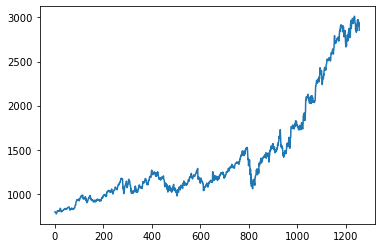

In [11]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [12]:
df1.shape

(1257,)

In [13]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [14]:
print(df1)

[[0.0101411 ]
 [0.00866944]
 [0.00806739]
 ...
 [0.9702055 ]
 [0.94763999]
 [0.92948501]]


In [15]:
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[:training_size,:],df1[training_size+1:,:]

In [16]:
def create_dataset(dataset,timesteps):
    dataX,dataY=[],[]
    for i in range(len(dataset)-timesteps-1):
        dataX.append(dataset[i:(i+timesteps),0])
        dataY.append(dataset[i+timesteps,0])
    return np.array(dataX), np.array(dataY)

In [17]:
time_step=200
X_train,Y_train=create_dataset(train_data,time_step)
X_test,Y_test=create_dataset(test_data,time_step)

In [18]:
print(Y_train.shape)

(616,)


In [19]:
#Reshape to use LSTM
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [21]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(200,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 200, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=50,
          batch_size=64,verbose=1)

Epoch 1/50
10/10 [==============================] - 15s 964ms/step - loss: 0.0052 - val_loss: 0.1519
Epoch 2/50
10/10 [==============================] - 9s 902ms/step - loss: 0.0016 - val_loss: 0.0629
Epoch 3/50
10/10 [==============================] - 9s 915ms/step - loss: 0.0011 - val_loss: 0.1002
Epoch 4/50
10/10 [==============================] - 6s 574ms/step - loss: 8.0889e-04 - val_loss: 0.0569
Epoch 5/50
10/10 [==============================] - 7s 692ms/step - loss: 7.5309e-04 - val_loss: 0.0375
Epoch 6/50
10/10 [==============================] - 5s 518ms/step - loss: 6.7805e-04 - val_loss: 0.0267
Epoch 7/50
10/10 [==============================] - 5s 532ms/step - loss: 6.2412e-04 - val_loss: 0.0231
Epoch 8/50
10/10 [==============================] - 4s 420ms/step - loss: 6.2074e-04 - val_loss: 0.0161
Epoch 9/50
10/10 [==============================] - 4s 418ms/step - loss: 6.0547e-04 - val_loss: 0.0125
Epoch 10/50
10/10 [==============================] - 4s 422ms/step - loss: 

In [24]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [25]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(Y_train,train_predict))

1166.2054693368623

In [26]:
math.sqrt(mean_squared_error(Y_test,test_predict))

1995.890210490183

In [27]:
len(df1)-(len(train_predict)+(2*lookback)+1)

NameError: name 'lookback' is not defined

In [28]:
lookback=200
trainPredictPlot=np.empty_like(df1)
trainPredictPlot[:,:]=np.nan
trainPredictPlot[lookback:len(train_predict)+lookback:,:]=train_predict
testPredictPlot=np.empty_like(df1)
testPredictPlot[:,:]=np.nan
testPredictPlot[len(train_predict)+(2*lookback)+2:len(df1)-1,:]=test_predict

In [29]:
testPredictPlot

array([[          nan],
       [          nan],
       [          nan],
       ...,
       [2419.60888672],
       [2427.3046875 ],
       [          nan]])

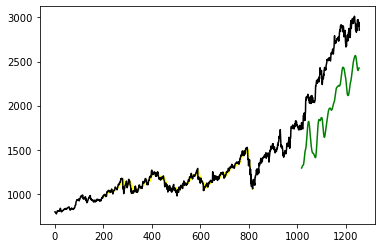

In [30]:
plt.plot(trainPredictPlot,color='yellow')
plt.plot(testPredictPlot,color='green')
plt.plot(scaler.inverse_transform(df1),color='black')
plt.show()

In [31]:
len(test_data)

439

In [36]:
x_input=test_data[239:].reshape(1,-1)
x_input.shape

(1, 200)

In [37]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [38]:
len(temp_input)

200

In [39]:
n_steps=200
i=0
lst_output=[]
while i<30:
    if len(temp_input)>n_steps:
        x_input=np.array(temp_input[1:])
        x_input=x_input.reshape(1,-1)
        x_input=x_input.reshape((1,n_steps,1))
        pred=model.predict(x_input,verbose=0)
        temp_input.extend(pred[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(pred.tolist())
    
    else:
        x_input=x_input.reshape((1,n_steps,1))
        pred=model.predict(x_input,verbose=0)
        temp_input.extend(pred[0].tolist())
        lst_output.extend(pred.tolist())
    i+=1
        

In [40]:
day_new=np.arange(1,201)
day_pred=np.arange(201,231)

In [41]:
len(lst_output)

30

In [42]:
df3=df1.tolist()
df3.extend(lst_output)

In [43]:
df1.shape

(1257, 1)

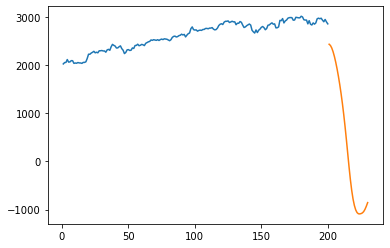

In [45]:
plt.plot(day_new,scaler.inverse_transform(df1[1057:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

In [ ]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3)